# Kmeans Clustering of Covid-19 regions
In this, part 3 section 6 of our Covid-19 study, we look at an abundance of possible features and try to determine which are most indicative of how a county in the United States will be affected by Covid-19

**Matt Paterson, hello@hireMattPaterson.com**<br>
**Machine Learning Engineer**<br>
**Cloud Brigade, Santa Cruz, CA**

In [1]:
# Import the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model      import LogisticRegression, LinearRegression
from sklearn.model_selection   import train_test_split, cross_val_score
from sklearn.cluster           import KMeans
from sklearn.decomposition     import PCA
from sklearn.preprocessing     import StandardScaler, OneHotEncoder, PolynomialFeatures

As we step through this notebook we will import a number of data sets. To start with, we'll see how the kmeans clustering algorithm creates a heatmap of the United States using the confirmed cases and deaths numbers.

In [2]:
path_to_home = '../'
datapath = path_to_home + 'data/'

In [4]:
# Pull in the dataframe that we created in the LinearRegression notebook
filename = '85_cols.csv'

covid_df = pd.read_csv(datapath + filename)
covid_df.head()

county_state  confirmed_cases  deaths  latitude  longitude  \
0     Adams County, Wisconsin            316.0     4.0     43.97     -89.77   
1   Ashland County, Wisconsin            197.0     2.0     46.71     -90.56   
2    Barron County, Wisconsin            624.0     6.0     45.42     -91.85   
3  Bayfield County, Wisconsin            156.0     1.0     46.63     -91.18   
4     Brown County, Wisconsin          11936.0    75.0     44.48     -87.99   

      fips  percapita_income  median_household_income  median_family_income  \
0  55001.0           22196.0                  44897.0               51949.0   
1  55003.0           21115.0                  38550.0               47587.0   
2  55005.0           23337.0                  44054.0               54827.0   
3  55007.0           25377.0                  44944.0               55654.0   
4  55009.0           27787.0                  53119.0               67159.0   

   number_of_households  ...  SD  TN  TX  UT  VA  VT  WA  WI  WV  WY  
0                8278.0  ...   0   0   0   0   0   0   0   1   0   0  
1                6775.0  ...   0   0   0   0   0   0   0   1   0   0  
2               19168.0  ...   0   0   0   0   0   0   0   1   0   0  
3                6964.0  ...   0   0   0   0   0   0   0   1   0   0  
4               98962.0  ...   0   0   0   0   0   0   0   1   0   0  

[5 rows x 86 columns]

Re-set the index to be the county-state column

In [6]:
covid_df.set_index('county_state', inplace=True)

We won't need some of these columns. Create a new dataframe that is a copy of the features that we need from this one

In [7]:
covid_df.columns

Index(['confirmed_cases', 'deaths', 'latitude', 'longitude', 'fips',
       'percapita_income', 'median_household_income', 'median_family_income',
       'number_of_households', 'Population', 'pct_white', 'pct_black',
       'pct_asian', 'pct_hispanic', 'pct_native_american', 'pct_hawaiian',
       'QMB_Only', 'QMB_plus_Full', 'SLMB_only', 'SLMB_plus_Full', 'QI',
       'Other_full', 'Public_Total', 'SNAP_PA_Participation_Persons',
       'SNAP_NPA_Participation_Persons', 'SNAP_All_Participation_Persons',
       'SNAP_PA_Participation_Households', 'SNAP_NPA_Participation_Households',
       'SNAP_All_Participation_Households', 'SNAP_All_Issuance',
       'deaths_per_100k', 'cases_per_100k', 'jobs_per_100k',
       'av_household_earnings_per_100k', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO',
       'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
       'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',

In [8]:
df = covid_df[['confirmed_cases', 'deaths', 'latitude', 'longitude', 'fips',
       'percapita_income', 'median_household_income', 'median_family_income',
       'number_of_households', 'Population', 'pct_white', 'pct_black',
       'pct_asian', 'pct_hispanic', 'pct_native_american', 'pct_hawaiian',
       'QMB_Only', 'QMB_plus_Full', 'SLMB_only', 'SLMB_plus_Full', 'QI',
       'Other_full', 'Public_Total', 'SNAP_PA_Participation_Persons',
       'SNAP_NPA_Participation_Persons', 'SNAP_All_Participation_Persons',
       'SNAP_PA_Participation_Households', 'SNAP_NPA_Participation_Households',
       'SNAP_All_Participation_Households', 'SNAP_All_Issuance',
       'deaths_per_100k', 'cases_per_100k', 'jobs_per_100k',
       'av_household_earnings_per_100k']]

In [9]:
df.head()

confirmed_cases  deaths  latitude  longitude  \
county_state                                                               
Adams County, Wisconsin               316.0     4.0     43.97     -89.77   
Ashland County, Wisconsin             197.0     2.0     46.71     -90.56   
Barron County, Wisconsin              624.0     6.0     45.42     -91.85   
Bayfield County, Wisconsin            156.0     1.0     46.63     -91.18   
Brown County, Wisconsin             11936.0    75.0     44.48     -87.99   

                               fips  percapita_income  \
county_state                                            
Adams County, Wisconsin     55001.0           22196.0   
Ashland County, Wisconsin   55003.0           21115.0   
Barron County, Wisconsin    55005.0           23337.0   
Bayfield County, Wisconsin  55007.0           25377.0   
Brown County, Wisconsin     55009.0           27787.0   

                            median_household_income  median_family_income  \
county_state                                                                
Adams County, Wisconsin                     44897.0               51949.0   
Ashland County, Wisconsin                   38550.0               47587.0   
Barron County, Wisconsin                    44054.0               54827.0   
Bayfield County, Wisconsin                  44944.0               55654.0   
Brown County, Wisconsin                     53119.0               67159.0   

                            number_of_households  Population  ...  \
county_state                                                  ...   
Adams County, Wisconsin                   8278.0     20220.0  ...   
Ashland County, Wisconsin                 6775.0     15562.0  ...   
Barron County, Wisconsin                 19168.0     45244.0  ...   
Bayfield County, Wisconsin                6964.0     15036.0  ...   
Brown County, Wisconsin                  98962.0    264542.0  ...   

                            SNAP_NPA_Participation_Persons  \
county_state                                                 
Adams County, Wisconsin                             2604.0   
Ashland County, Wisconsin                           2121.0   
Barron County, Wisconsin                            4503.0   
Bayfield County, Wisconsin                          1106.0   
Brown County, Wisconsin                            19848.0   

                            SNAP_All_Participation_Persons  \
county_state                                                 
Adams County, Wisconsin                             2958.0   
Ashland County, Wisconsin                           2350.0   
Barron County, Wisconsin                            5078.0   
Bayfield County, Wisconsin                          1235.0   
Brown County, Wisconsin                            22738.0   

                            SNAP_PA_Participation_Households  \
county_state                                                   
Adams County, Wisconsin                                204.0   
Ashland County, Wisconsin                              143.0   
Barron County, Wisconsin                               351.0   
Bayfield County, Wisconsin                              94.0   
Brown County, Wisconsin                               1503.0   

                            SNAP_NPA_Participation_Households  \
county_state                                                    
Adams County, Wisconsin                                1462.0   
Ashland County, Wisconsin                              1019.0   
Barron County, Wisconsin                               2304.0   
Bayfield County, Wisconsin                              560.0   
Brown County, Wisconsin                                9300.0   

                            SNAP_All_Participation_Households  \
county_state                                                    
Adams County, Wisconsin                                1666.0   
Ashland County, Wisconsin                              1162.0   
Barron County, Wisconsin            

In [10]:
df.shape

(3040, 34)

## Latitude and Longitude Covid Map

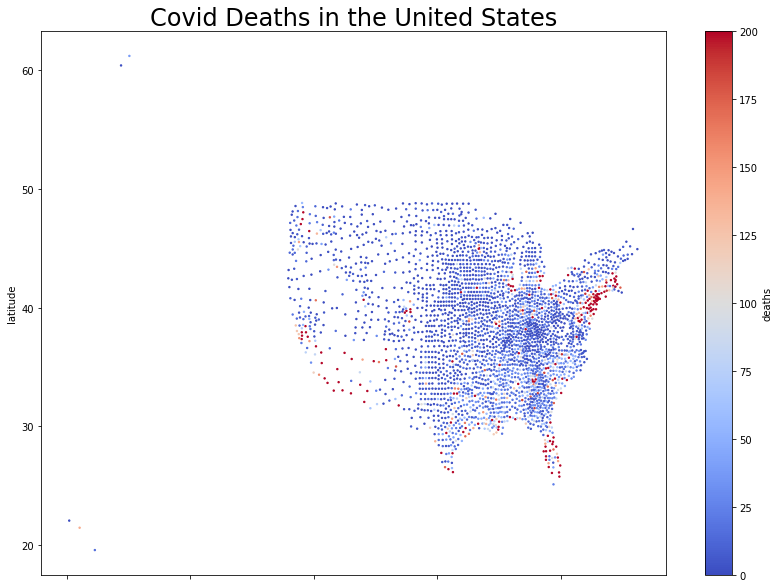

In [11]:
df.plot(kind="scatter", x="longitude", y="latitude", c="deaths",
         cmap="coolwarm", figsize=(14, 10), s=2, vmin=200, vmax=0);
plt.title("Covid Deaths in the United States", fontsize=24);

Make our map more readable using only the lower forty-eight states

In [15]:
df_lower = covid_df[(covid_df['AK'] == 0) & (covid_df['HI'] == 0)]

In [68]:
df_lower.to_csv(datapath + 'cov_soc_eco_lower48.csv')

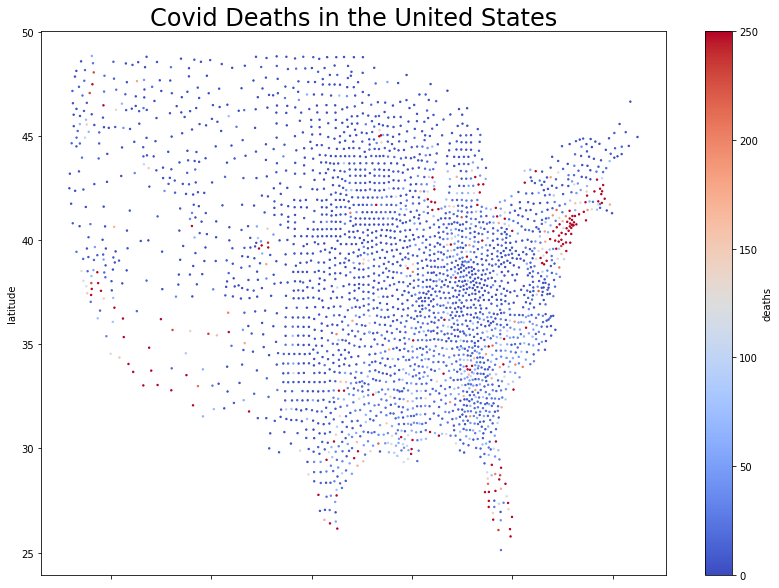

In [16]:
df_lower.plot(kind="scatter", x="longitude", y="latitude", c="deaths",
         cmap="coolwarm", figsize=(14, 10), s=2, vmin=250, vmax=0);
plt.title("Covid Deaths in the United States", fontsize=24);

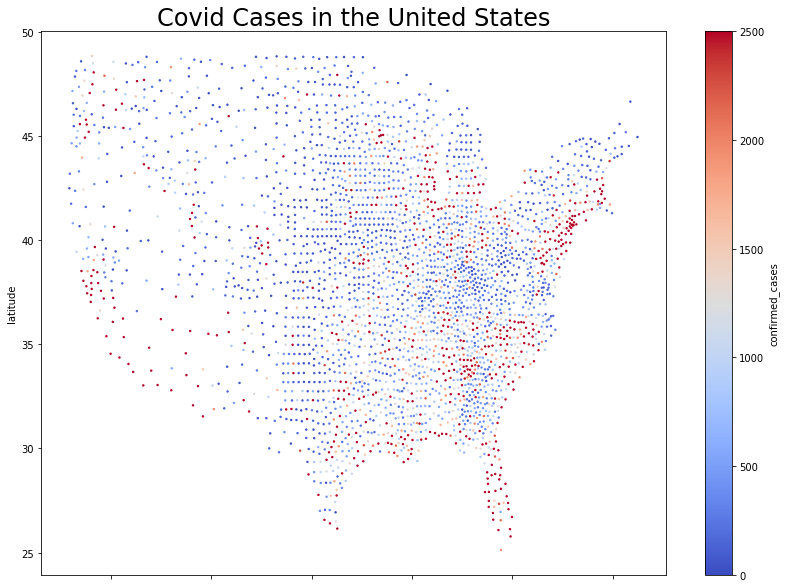

In [17]:
df_lower.plot(kind="scatter", x="longitude", y="latitude", c="confirmed_cases",
         cmap="coolwarm", figsize=(14, 10), s=2, vmin=2500, vmax=0);
plt.title("Covid Cases in the United States", fontsize=24);

The above map is only using geo-spatial data. We want to now start introducing features to model on, and see what areas in this map share traits and how the Kmeans clustering algorithm can lend us insight into the pandemic

## Part A: get a baseline look

In [18]:
# Instantiate a KMeans model with 100 clusters
km = KMeans(n_clusters=100)

Do a train_test_split of the data set, and then run it through the standard scaler before setting it in to the PCA algorithm

In [19]:

all_feats = []
for col in df_lower.columns:
    print("'"+col+"',")
all_feats = list(df_lower.columns)

'confirmed_cases',
'deaths',
'latitude',
'longitude',
'fips',
'percapita_income',
'median_household_income',
'median_family_income',
'number_of_households',
'Population',
'pct_white',
'pct_black',
'pct_asian',
'pct_hispanic',
'pct_native_american',
'pct_hawaiian',
'QMB_Only',
'QMB_plus_Full',
'SLMB_only',
'SLMB_plus_Full',
'QI',
'Other_full',
'Public_Total',
'SNAP_PA_Participation_Persons',
'SNAP_NPA_Participation_Persons',
'SNAP_All_Participation_Persons',
'SNAP_PA_Participation_Households',
'SNAP_NPA_Participation_Households',
'SNAP_All_Participation_Households',
'SNAP_All_Issuance',
'deaths_per_100k',
'cases_per_100k',
'jobs_per_100k',
'av_household_earnings_per_100k',
'AK',
'AL',
'AR',
'AZ',
'CA',
'CO',
'CT',
'DC',
'DE',
'FL',
'GA',
'HI',
'IA',
'ID',
'IL',
'IN',
'KS',
'KY',
'LA',
'MA',
'MD',
'ME',
'MI',
'MN',
'MO',
'MS',
'MT',
'NC',
'ND',
'NE',
'NH',
'NJ',
'NM',
'NV',
'NY',
'OH',
'OK',
'OR',
'PA',
'RI',
'SC',
'SD',
'TN',
'TX',
'UT',
'VA',
'VT',
'WA',
'WI',
'WV',
'WY',


In [20]:
# make a features list without the state columns
features = []
features = list(df.columns)

In [22]:
targets_list = ['confirmed_cases', 'deaths', 'deaths_per_100k', 'cases_per_100k']

In [23]:
geog = ['latitude', 'longitude']
no_need_cols = ['latitude', 'longitude', 'fips']
for feat in no_need_cols:
    all_feats.remove(feat)

In [25]:
# Use Standard Scaler on the data so that it fits in Kmeans

X = df_lower[all_feats]

# Instantiate our StandardScaler
ss = StandardScaler()

# Standardize
X_sc = ss.fit_transform(X)

In [26]:
# fit the kmeans model to the training data
km.fit(X_sc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [41]:
# # Use KMeans to cluster geographically and then graph for a look
# kmg = KMeans(n_clusters=100)
# kmg.fit(geog_clus)
# plt.figure(figsize=(10, 10))
# plt.scatter(dri_model.longitude, dri_model.latitude, c=kmg.labels_, s=1, cmap="tab20");

Map out the clusters. We dropped Alaska and Hawaii so that we can see our map more clearly.

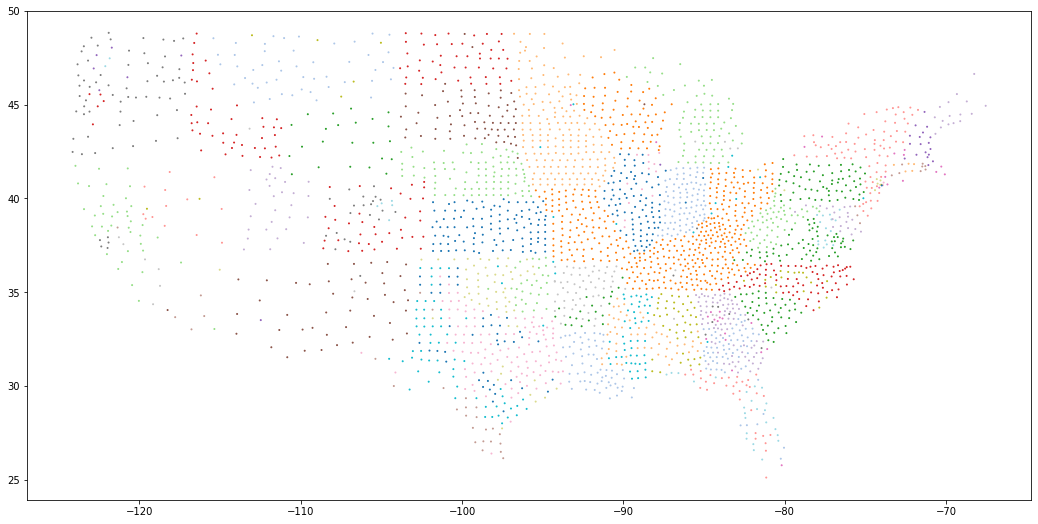

In [27]:
plt.figure(figsize=(18, 9))
plt.scatter(df_lower.longitude, df_lower.latitude, c=km.labels_, s=1, cmap='tab20');

Put this into an algorithm

In [28]:
def cluster_map(data, features, n_clusters, cmap='tab20'):
    '''
    Returns a kmeans clustering model of the DataFrame data and prints a map
            provided the dataset contains latitude and longitude data
    data    a Pandas DataFrame, must contain a column titled 'longitude' and
            also must contain a column titled 'latitude'
    features a list of numeric columns, all categorical data must be one-hot-encoded,
             this list will be used to build the KMeans model from the data DataFrame
             thus the list should match the DataFrame columns and is case-sensitive
    n_clusters an int, the number of clusters the KMeans model should return
    cmap    the color-scheme for the map
    '''
    
    # Un-comment these imports if porting this function to a library
    # import pandas as pd
    # from sklearn.cluster           import KMeans
    # from sklearn.decomposition     import PCA
    # from sklearn.preprocessing     import StandardScaler
    
    # create the scaled features matrix
    X = data[features]
    ss = StandardScaler()
    X_sc = ss.fit_transform(X)
    
    # create the cluster model
    model = KMeans(n_clusters = n_clusters)
    model.fit(X_sc)
    
    # map the resulting clusters
    plt.figure(figsize=(18, 9))
    plt.title(f'Map of {n_clusters} Clusters, Clusters like similar colored clusters', 
             fontsize = 36)
    plt.scatter(data.longitude, data.latitude, c=model.labels_, s=1, cmap=cmap);
    
    return model

## Remove the state designations
It is clear that above, our Kmeans algorithm is clustering data based on the binary columns for each state. We should remove this to see some more worthwhile results

In [29]:
states = [
'AK',
'AL',
'AR',
'AZ',
'CA',
'CO',
'CT',
'DC',
'DE',
'FL',
'GA',
'HI',
'IA',
'ID',
'IL',
'IN',
'KS',
'KY',
'LA',
'MA',
'MD',
'ME',
'MI',
'MN',
'MO',
'MS',
'MT',
'NC',
'ND',
'NE',
'NH',
'NJ',
'NM',
'NV',
'NY',
'OH',
'OK',
'OR',
'PA',
'RI',
'SC',
'SD',
'TN',
'TX',
'UT',
'VA',
'VT',
'WA',
'WI',
'WV',
'WY'
]

In [30]:
for state in states:
    all_feats.remove(state)
len(all_feats)

31

## Iterate over several possible combinations of features and number of clusters

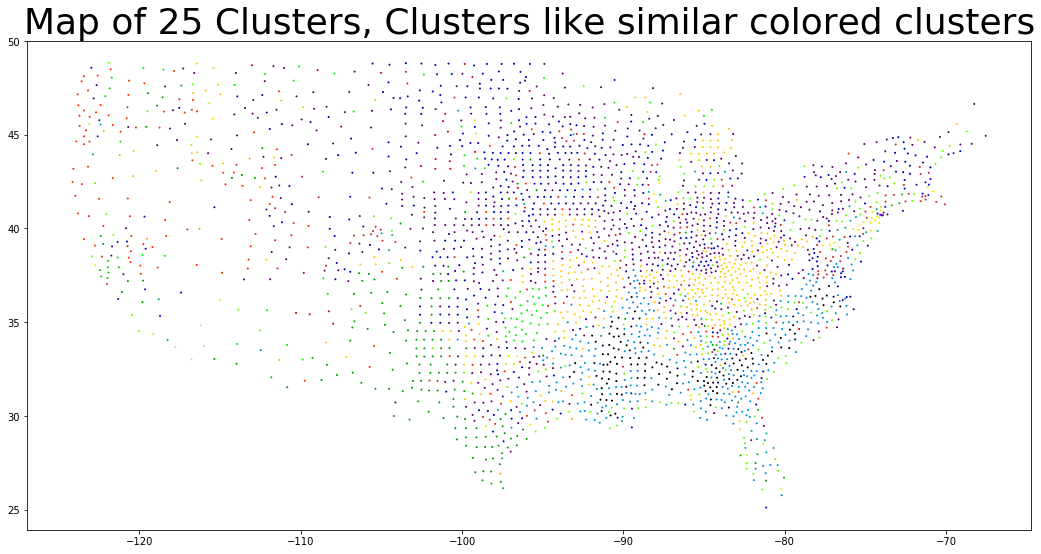

In [31]:
cluster_map(df_lower, all_feats, 25, cmap='nipy_spectral');

## Set the color map here, colors = cmap

In [48]:
colors = 'nipy_spectral'

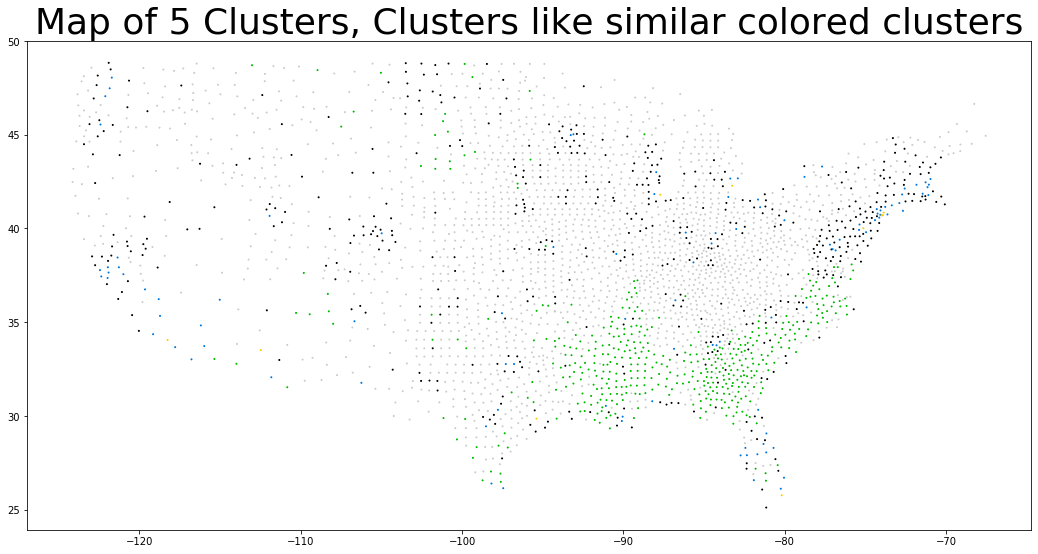

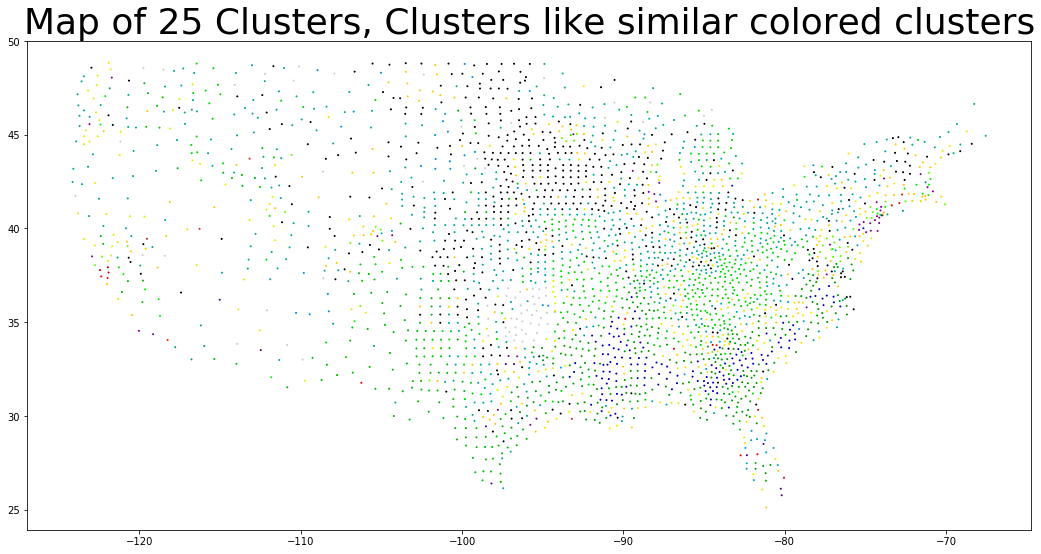

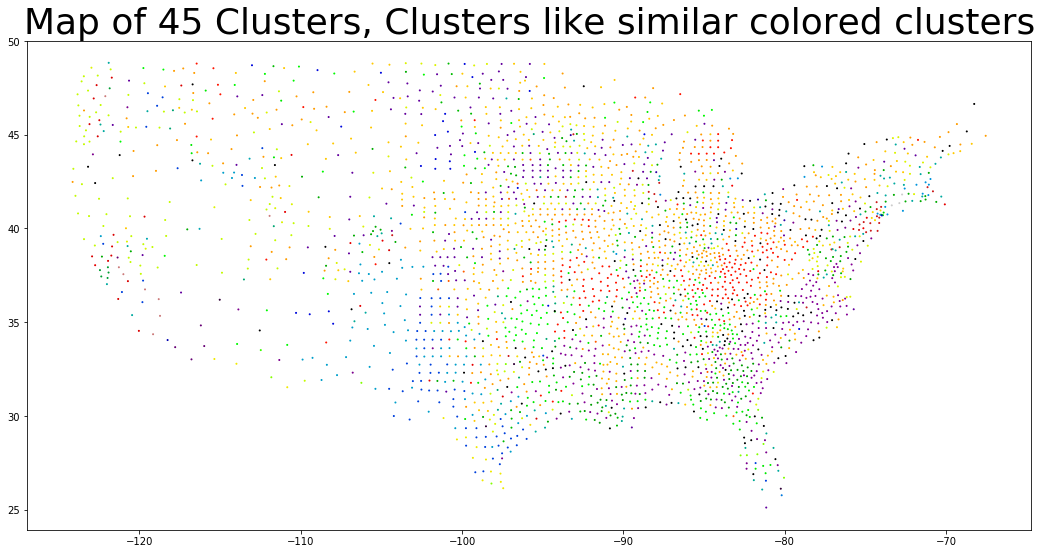

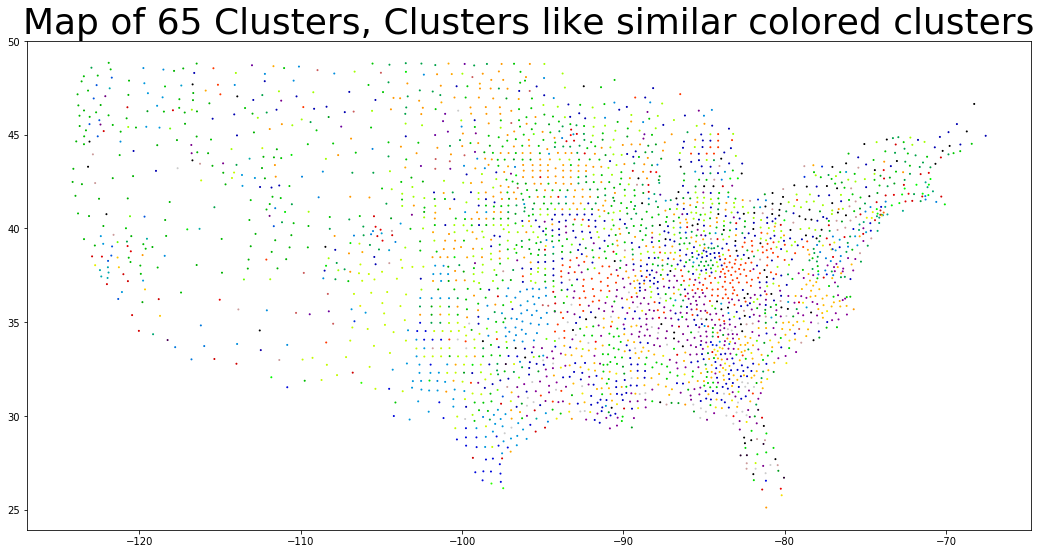

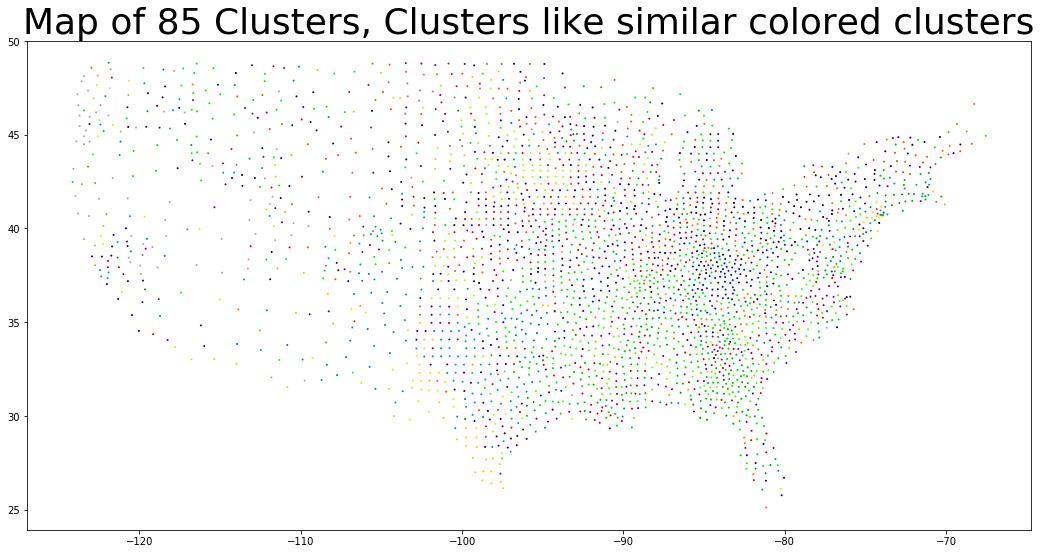

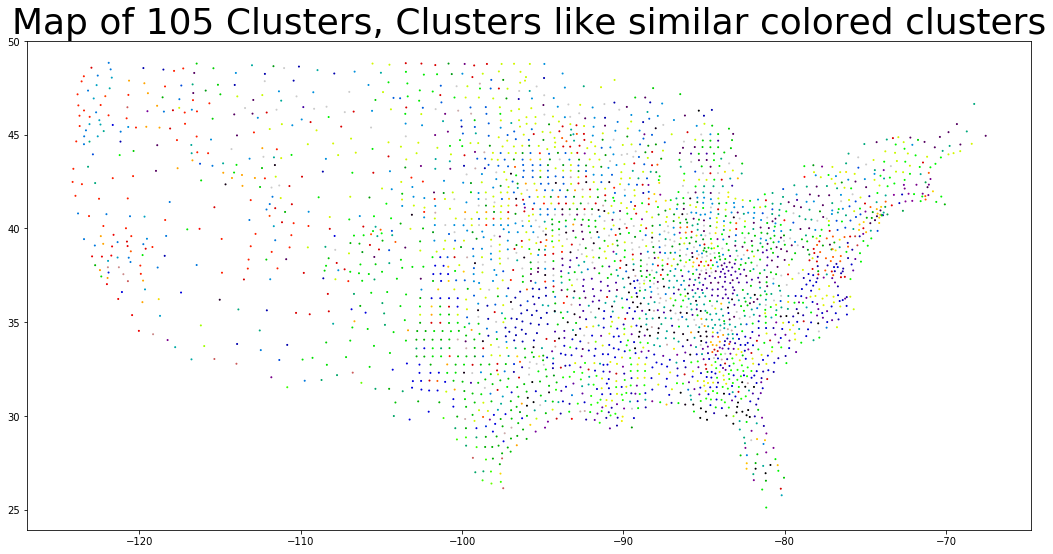

In [49]:

for i in range(5, 125, 20):
    cluster_map(df_lower, all_feats, i, cmap=colors);

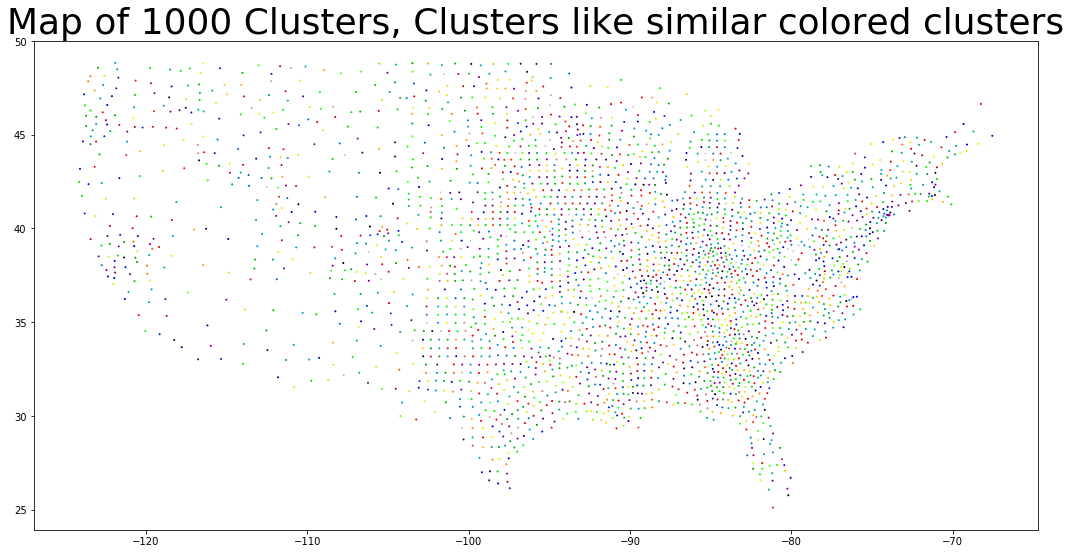

In [50]:
cluster_map(df_lower, all_feats, 1000, cmap=colors);

In [36]:
covid_feats = ['confirmed_cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']

In [37]:
racial = [
    'pct_white',
 'pct_black',
 'pct_asian',
 'pct_hispanic',
 'pct_native_american',
 'pct_hawaiian',
]

econ = [
    'percapita_income',
 'median_household_income',
 'median_family_income',
 'number_of_households',
    'QMB_Only',
 'QMB_plus_Full',
 'SLMB_only',
 'SLMB_plus_Full',
 'QI',
 'Other_full',
 'Public_Total',
 'SNAP_PA_Participation_Persons',
 'SNAP_NPA_Participation_Persons',
 'SNAP_All_Participation_Persons',
 'SNAP_PA_Participation_Households',
 'SNAP_NPA_Participation_Households',
 'SNAP_All_Participation_Households',
 'SNAP_All_Issuance',
 'jobs_per_100k',
 'av_household_earnings_per_100k'
]

socio_econ = [
    'percapita_income',
 'median_household_income',
 'median_family_income',
 'number_of_households',
 'Population',
 'pct_white',
 'pct_black',
 'pct_asian',
 'pct_hispanic',
 'pct_native_american',
 'pct_hawaiian',
 'QMB_Only',
 'QMB_plus_Full',
 'SLMB_only',
 'SLMB_plus_Full',
 'QI',
 'Other_full',
 'Public_Total',
 'SNAP_PA_Participation_Persons',
 'SNAP_NPA_Participation_Persons',
 'SNAP_All_Participation_Persons',
 'SNAP_PA_Participation_Households',
 'SNAP_NPA_Participation_Households',
 'SNAP_All_Participation_Households',
 'SNAP_All_Issuance',
 'jobs_per_100k',
 'av_household_earnings_per_100k'
]

Racial Demographis Only


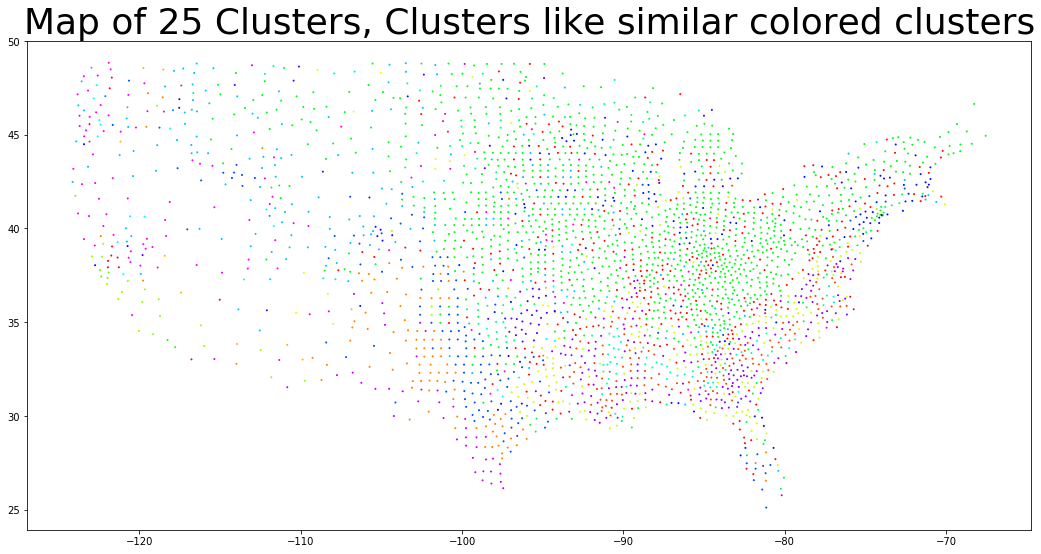

In [64]:
colors = 'gist_rainbow'
print('Racial Demographis Only')
cluster_map(df_lower, racial, 25, cmap=colors);

Covid Numbers Only


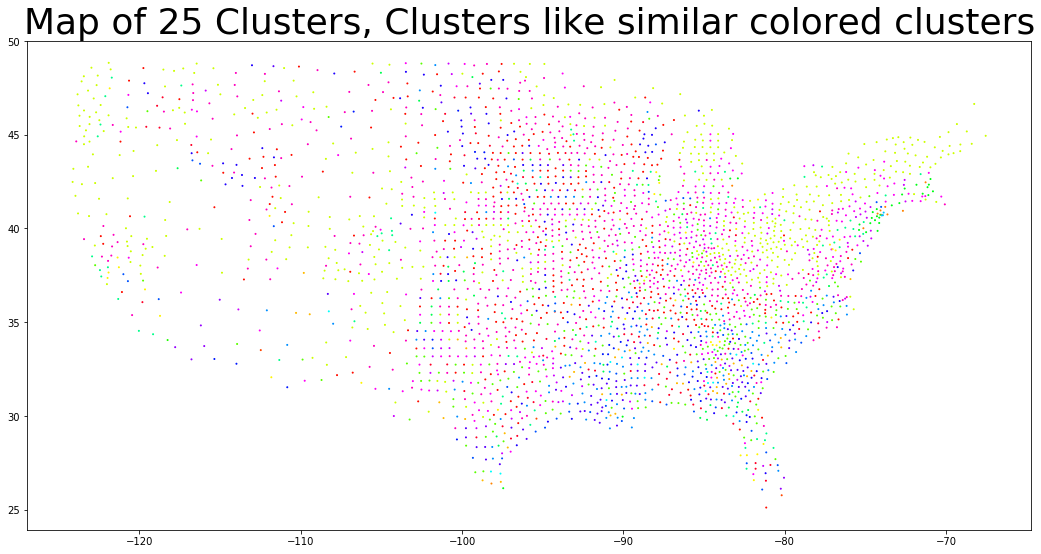

In [65]:
print('Covid Numbers Only')
cluster_map(df_lower, covid_feats, 25, colors);

Economics Numbers Only


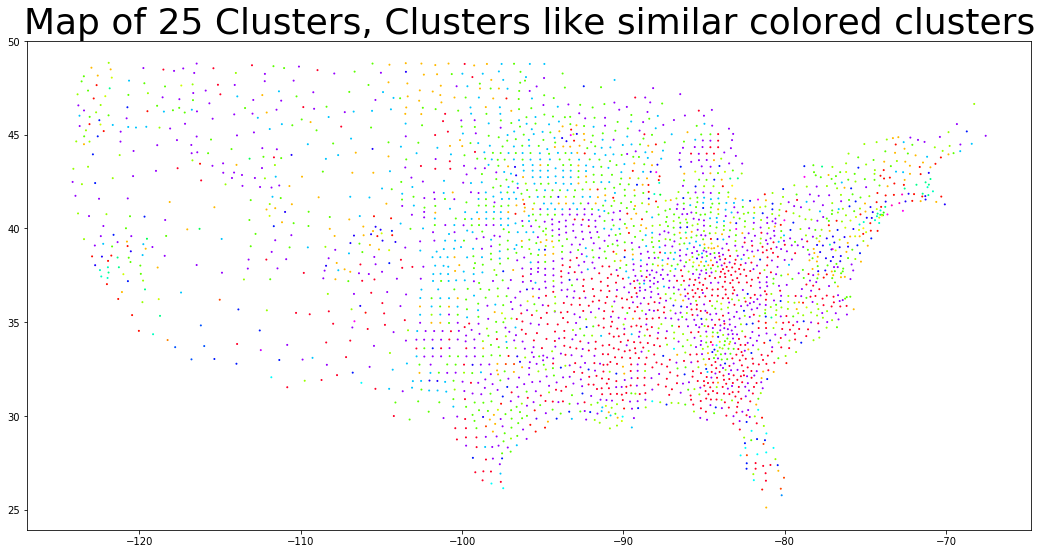

In [66]:
print('Economics Numbers Only')
cluster_map(df_lower, econ, 25, colors);

Socio-Economics Numbers Only


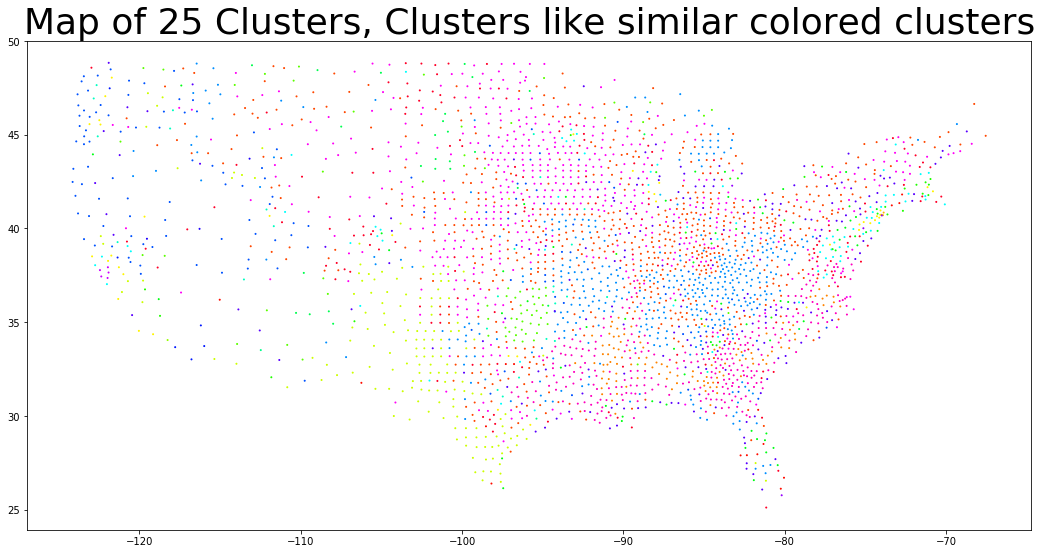

In [67]:
print('Socio-Economics Numbers Only')
cluster_map(df_lower, socio_econ, 25, colors);

## Feature Engineering
We want to look at a few numbers more quickly, such as deaths per capita in a county

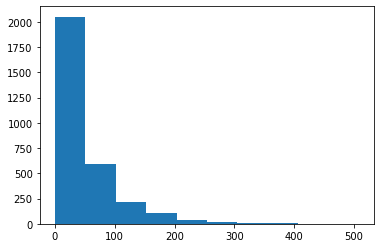

In [43]:
plt.hist(df_lower['deaths_per_100k']);

We see that the majority of counties have less than 100 deaths per 100K

## Send to Tableau

The above cluster maps help us to see patterns in the data such as geographic areas that have a lot of similarities and how the clusters of covid cases and deaths relate to the clusters of socio-economic data. However, we are using the latitude and logitude points for each county as the point of reference, and this can make it slightly harder to see.

As such, let's port this over to Tableau or Google Data Studio to see how they look in a different setting. We should also look in to GeoPandas to see if that library will help us render better maps.

In [46]:
df_lower['deaths_per_100k'].sort_values(ascending=False).head(10)

county_state
Hancock County, Georgia             508.454535
Kenedy County, Texas                495.049505
Randolph County, Georgia            427.854824
East Feliciana Parish, Louisiana    386.725895
Terrell County, Georgia             375.102567
Neshoba County, Mississippi         374.338897
McKinley County, New Mexico         362.912831
Holmes County, Mississippi          352.733686
Perkins County, Nebraska            345.901072
Jenkins County, Georgia             345.781466
Name: deaths_per_100k, dtype: float64

## Above, the 10 deadliest counties per capita

## Below, the 25 deadliest counties per capita

In [47]:
df_lower['deaths_per_100k'].sort_values(ascending=False).head(25)

county_state
Hancock County, Georgia             508.454535
Kenedy County, Texas                495.049505
Randolph County, Georgia            427.854824
East Feliciana Parish, Louisiana    386.725895
Terrell County, Georgia             375.102567
Neshoba County, Mississippi         374.338897
McKinley County, New Mexico         362.912831
Holmes County, Mississippi          352.733686
Perkins County, Nebraska            345.901072
Jenkins County, Georgia             345.781466
Brooks County, Texas                324.263358
Sharkey County, Mississippi         323.999074
Early County, Georgia               323.846909
Clarke County, Mississippi          308.860434
Turner County, Georgia              300.563557
Leflore County, Mississippi         290.955541
Wilcox County, Georgia              289.519398
Red River Parish, Louisiana         284.292822
Bronx County, New York              284.020598
Lowndes County, Alabama             277.606416
Starr County, Texas                 269.212322


In [71]:
print("National Averages for Percapita Income")
df_lower['percapita_income'].describe()

National Averages for Percapita Income


count     3035.000000
mean     23479.724997
std       5353.725104
min       8768.000000
25%      19885.000000
50%      22857.000000
75%      26106.121318
max      62018.000000
Name: percapita_income, dtype: float64

## It's tough out in the country
All of the 10 deadliest counties and most of the 25 deadliest are rural counties. This runs contrary to the normal thought process that densely populated cities would be the deadliest areas.

In the next cell, let's look at Willacy County, Texas, the 25th most deadly county in the nation. It has only about 21,000 residents, about 18,585 of which are Hispanic people, and only 1,475 or so are non-hispanic white people.

Percapita personal income in the county is 11,313 per year.

In [85]:
print('Population            ', df_lower.loc['Willacy County, Texas']['Population'])
print('percapita_income      ', df_lower.loc['Willacy County, Texas']['percapita_income'])
df_lower.loc['Willacy County, Texas'][racial]

Population             21358.0
percapita_income       11313.0


pct_white              0.955567
pct_black              0.030106
pct_asian              0.009832
pct_hispanic           0.885289
pct_native_american    0.009411
pct_hawaiian           0.000936
Name: Willacy County, Texas, dtype: float64

Similarly, Brooks County, Texas is the number 11 deadliest county in the country, with 324 deaths per 100K in the county, and has a 91% hispanic population, with only about 5.5% non-hispanic white. Also quite rural, Brooks County has only 7100 residents.

The Percapita personal income is 14K.

In [86]:
print('Population            ', df_lower.loc['Brooks County, Texas']['Population'])
print('percapita_income      ', df_lower.loc['Brooks County, Texas']['percapita_income'])
df_lower.loc['Brooks County, Texas'][racial]

Population             7093.0
percapita_income       14345.0


pct_white              0.970111
pct_black              0.013112
pct_asian              0.012266
pct_hispanic           0.914000
pct_native_american    0.009023
pct_hawaiian           0.000846
Name: Brooks County, Texas, dtype: float64

Look at the least-deadly counties in the country:

In [88]:
df_lower['deaths_per_100k'].sort_values().head(25)

county_state
Powder River County, Montana          0.0
Campbell County, South Dakota         0.0
Hemphill County, Texas                0.0
Golden Valley County, North Dakota    0.0
Hinsdale County, Colorado             0.0
Glasscock County, Texas               0.0
Sully County, South Dakota            0.0
Harding County, South Dakota          0.0
Jones County, South Dakota            0.0
Stanley County, South Dakota          0.0
Sterling County, Texas                0.0
Irion County, Texas                   0.0
Cimarron County, Oklahoma             0.0
Potter County, South Dakota           0.0
Aurora County, South Dakota           0.0
Lane County, Kansas                   0.0
Highland County, Virginia             0.0
Mineral County, Colorado              0.0
San Juan County, Colorado             0.0
Converse County, Wyoming              0.0
Albany County, Wyoming                0.0
Uintah County, Utah                   0.0
Carbon County, Utah                   0.0
Jefferson County, Was

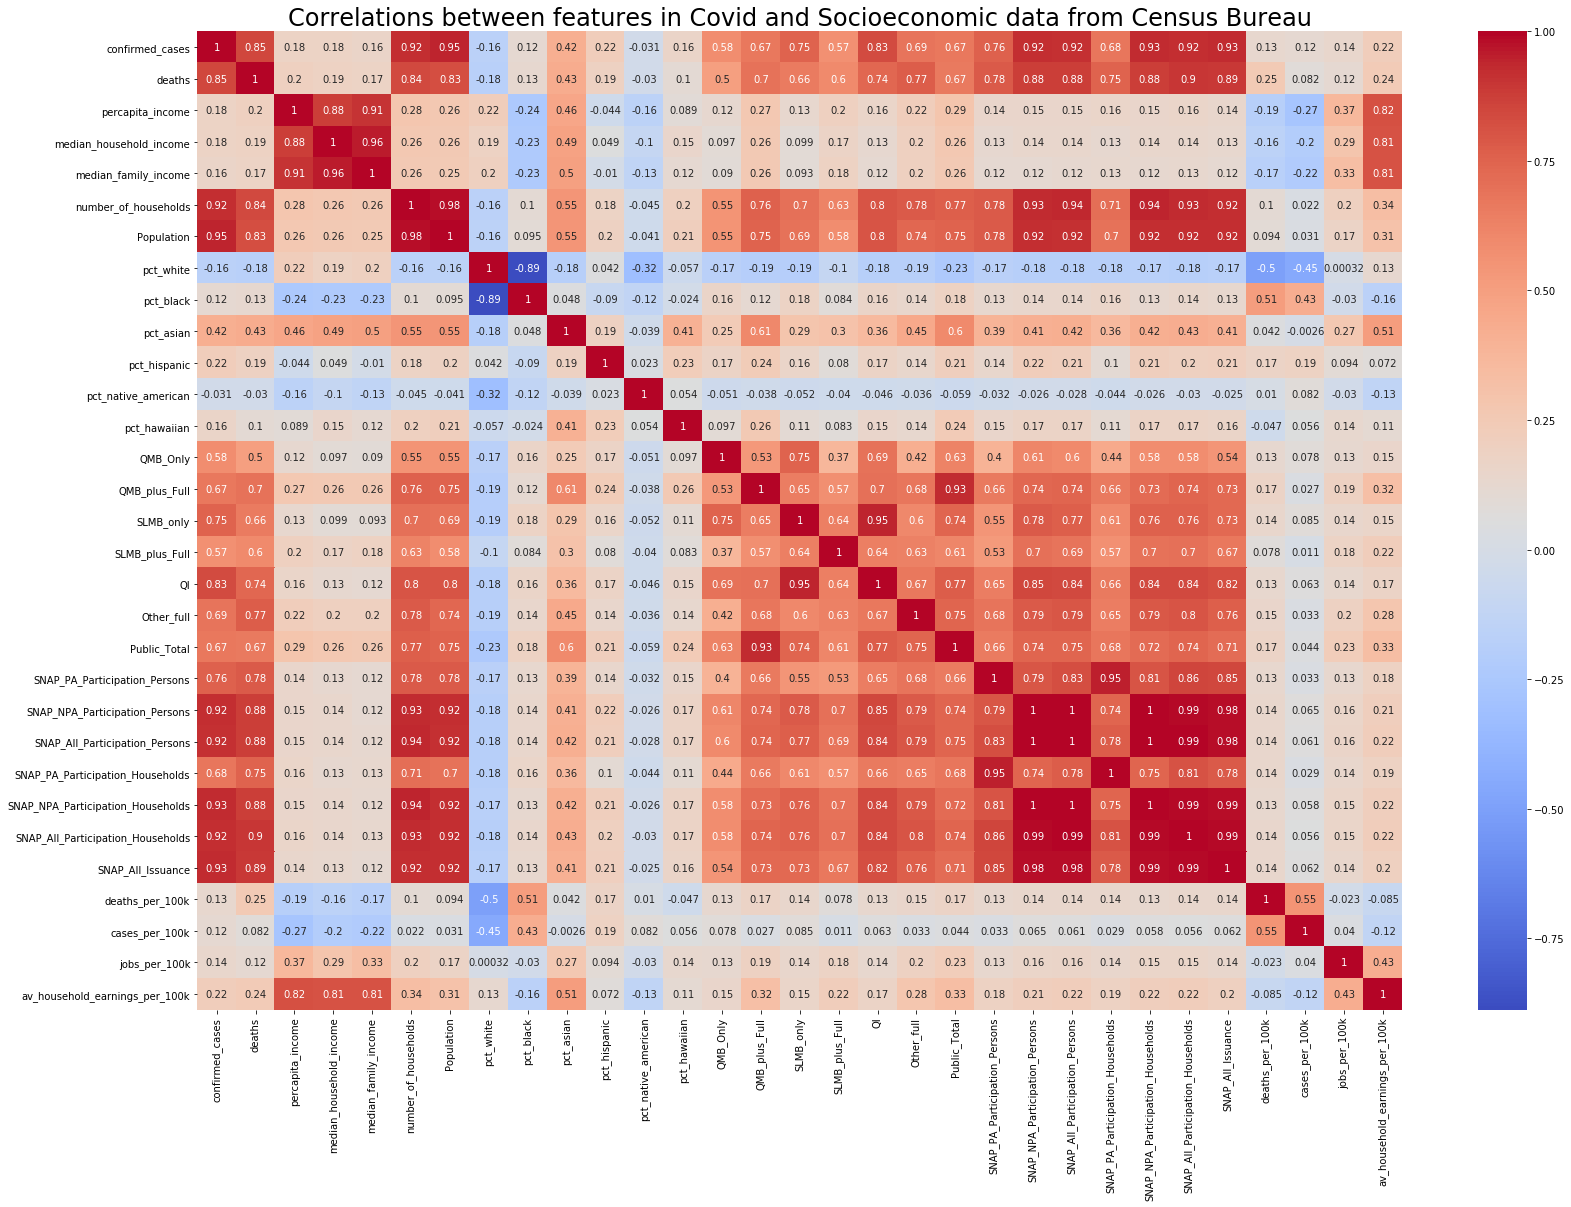

In [91]:

plt.figure(figsize=(27, 18))
sns.heatmap(df_lower[all_feats].corr(), cmap='coolwarm', annot=True);
plt.title("Correlations between features in Covid and Socioeconomic data from Census Bureau", fontsize=24);

## More Feature Engineering

It would be good for a last step to create percapita columns for the SNAP and Medicare benefits rows

In [99]:
df_lower.columns

Index(['confirmed_cases', 'deaths', 'latitude', 'longitude', 'fips',
       'percapita_income', 'median_household_income', 'median_family_income',
       'number_of_households', 'Population', 'pct_white', 'pct_black',
       'pct_asian', 'pct_hispanic', 'pct_native_american', 'pct_hawaiian',
       'QMB_Only', 'QMB_plus_Full', 'SLMB_only', 'SLMB_plus_Full', 'QI',
       'Other_full', 'Public_Total', 'SNAP_PA_Participation_Persons',
       'SNAP_NPA_Participation_Persons', 'SNAP_All_Participation_Persons',
       'SNAP_PA_Participation_Households', 'SNAP_NPA_Participation_Households',
       'SNAP_All_Participation_Households', 'SNAP_All_Issuance',
       'deaths_per_100k', 'cases_per_100k', 'jobs_per_100k',
       'av_household_earnings_per_100k', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO',
       'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
       'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',

In [106]:
#df_lower[['Population', 'SNAP_All_Participation_Persons']]
df_lower['percapita_SNAP'] = df_lower['SNAP_All_Participation_Persons'] / df_lower['Population']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
df_lower['percapita_SNAP']

county_state
Adams County, Wisconsin         0.146291
Ashland County, Wisconsin       0.151009
Barron County, Wisconsin        0.112236
Bayfield County, Wisconsin      0.082136
Brown County, Wisconsin         0.085952
                                  ...   
Treasure County, Montana        0.625350
Camas County, Idaho             0.623421
Daniels County, Montana         0.185109
Fallon County, Montana          0.177365
Powder River County, Montana    0.361216
Name: percapita_SNAP, Length: 3035, dtype: float64

In [108]:
df_lower['percent_households_SNAP'] = df_lower['SNAP_All_Participation_Households'] / df_lower['number_of_households']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [109]:
df_lower['percent_households_SNAP']

county_state
Adams County, Wisconsin         0.201256
Ashland County, Wisconsin       0.171513
Barron County, Wisconsin        0.138512
Bayfield County, Wisconsin      0.093912
Brown County, Wisconsin         0.109163
                                  ...   
Treasure County, Montana        0.936536
Camas County, Idaho             0.607406
Daniels County, Montana         0.293470
Fallon County, Montana          0.157375
Powder River County, Montana    0.348213
Name: percent_households_SNAP, Length: 3035, dtype: float64

In [111]:
all_feats.append('percapita_SNAP')
all_feats.append('percent_households_SNAP')

In [115]:
df_lower['percapita_medicare_medicade'] = df_lower['QMB_plus_Full'] / df_lower['Population']
df_lower['percapita_spec_low_inc_med'] = df_lower['SLMB_plus_Full'] / df_lower['Population']
df_lower['percapita_QI_med'] = df_lower['QI'] / df_lower['Population']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [116]:
all_feats.append('percapita_medicare_medicade')
all_feats.append('percapita_spec_low_inc_med')
all_feats.append('percapita_QI_med')

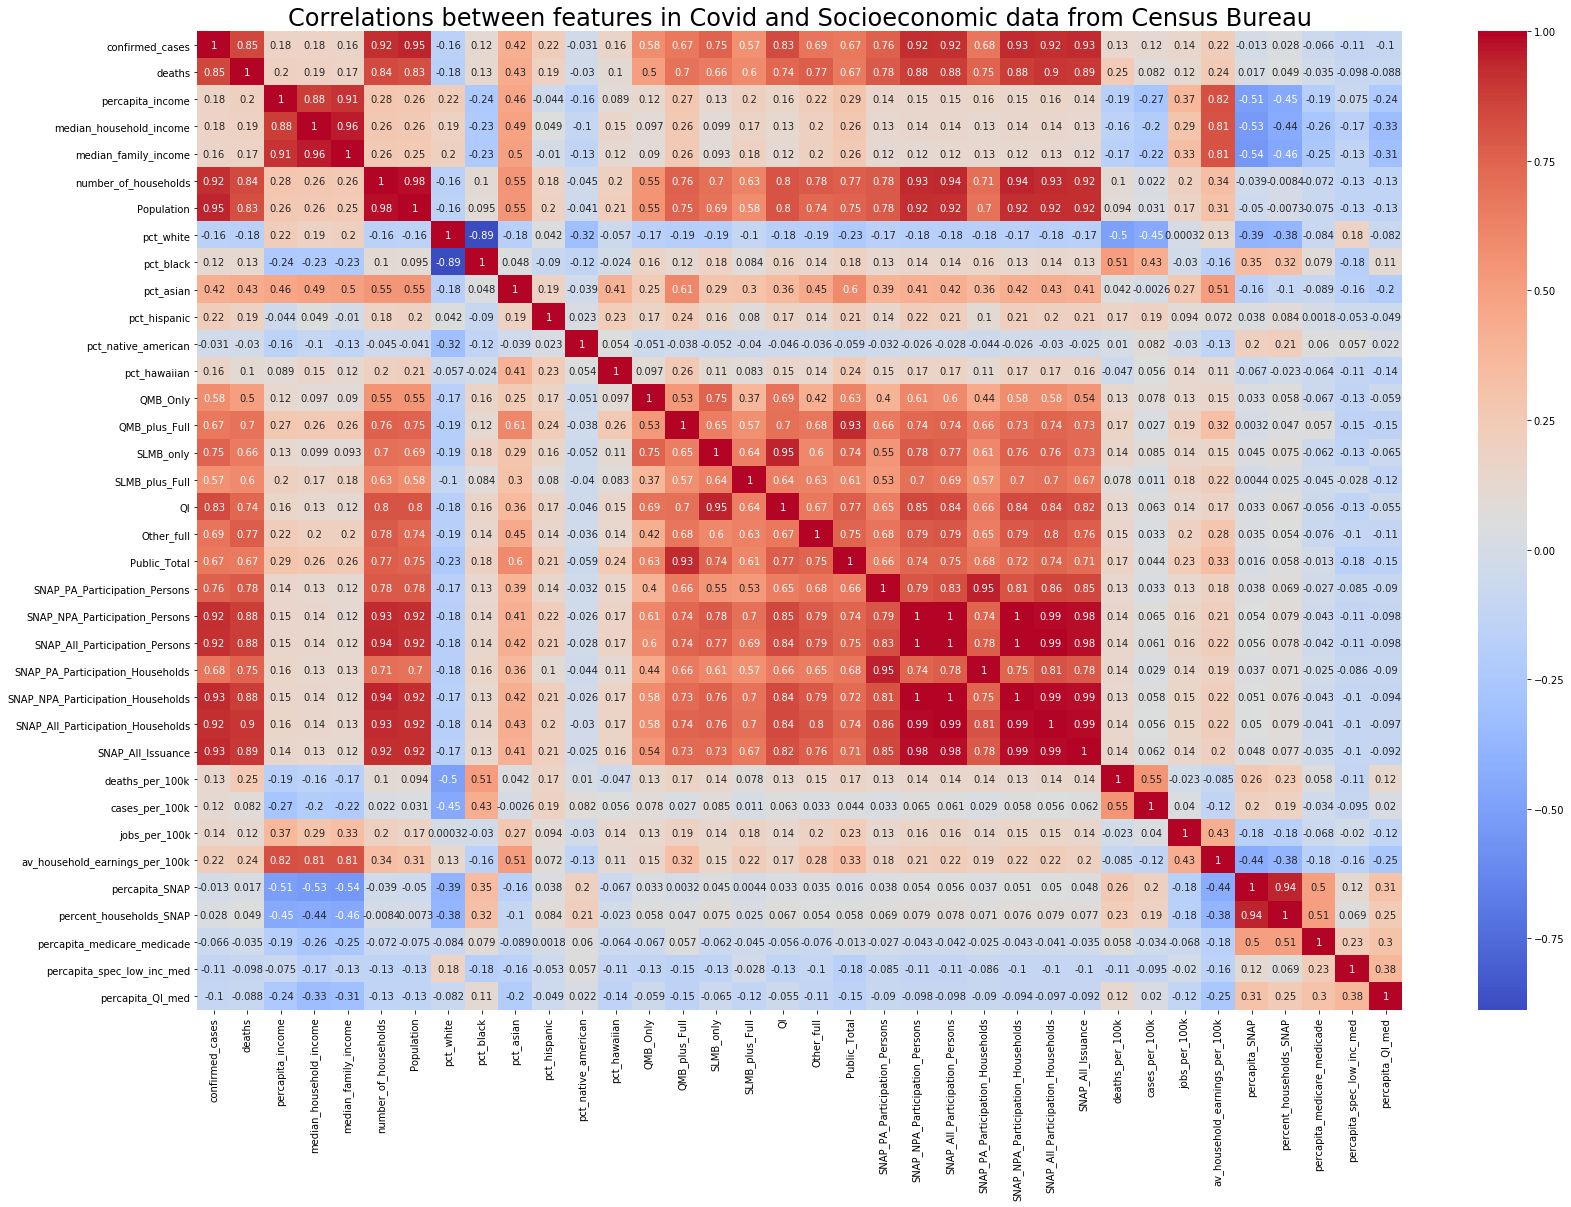

In [117]:

plt.figure(figsize=(27, 18))
sns.heatmap(df_lower[all_feats].corr(), cmap='coolwarm', annot=True);
plt.title("Correlations between features in Covid and Socioeconomic data from Census Bureau", fontsize=24);

In [124]:
percapita = ['Population','number_of_households', 'percapita_income', 'median_household_income',
             'median_family_income', 'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic',
            'pct_native_american', 'jobs_per_100k', 'percent_households_SNAP', 
             'percapita_medicare_medicade', 'percapita_spec_low_inc_med', 'percapita_QI_med']


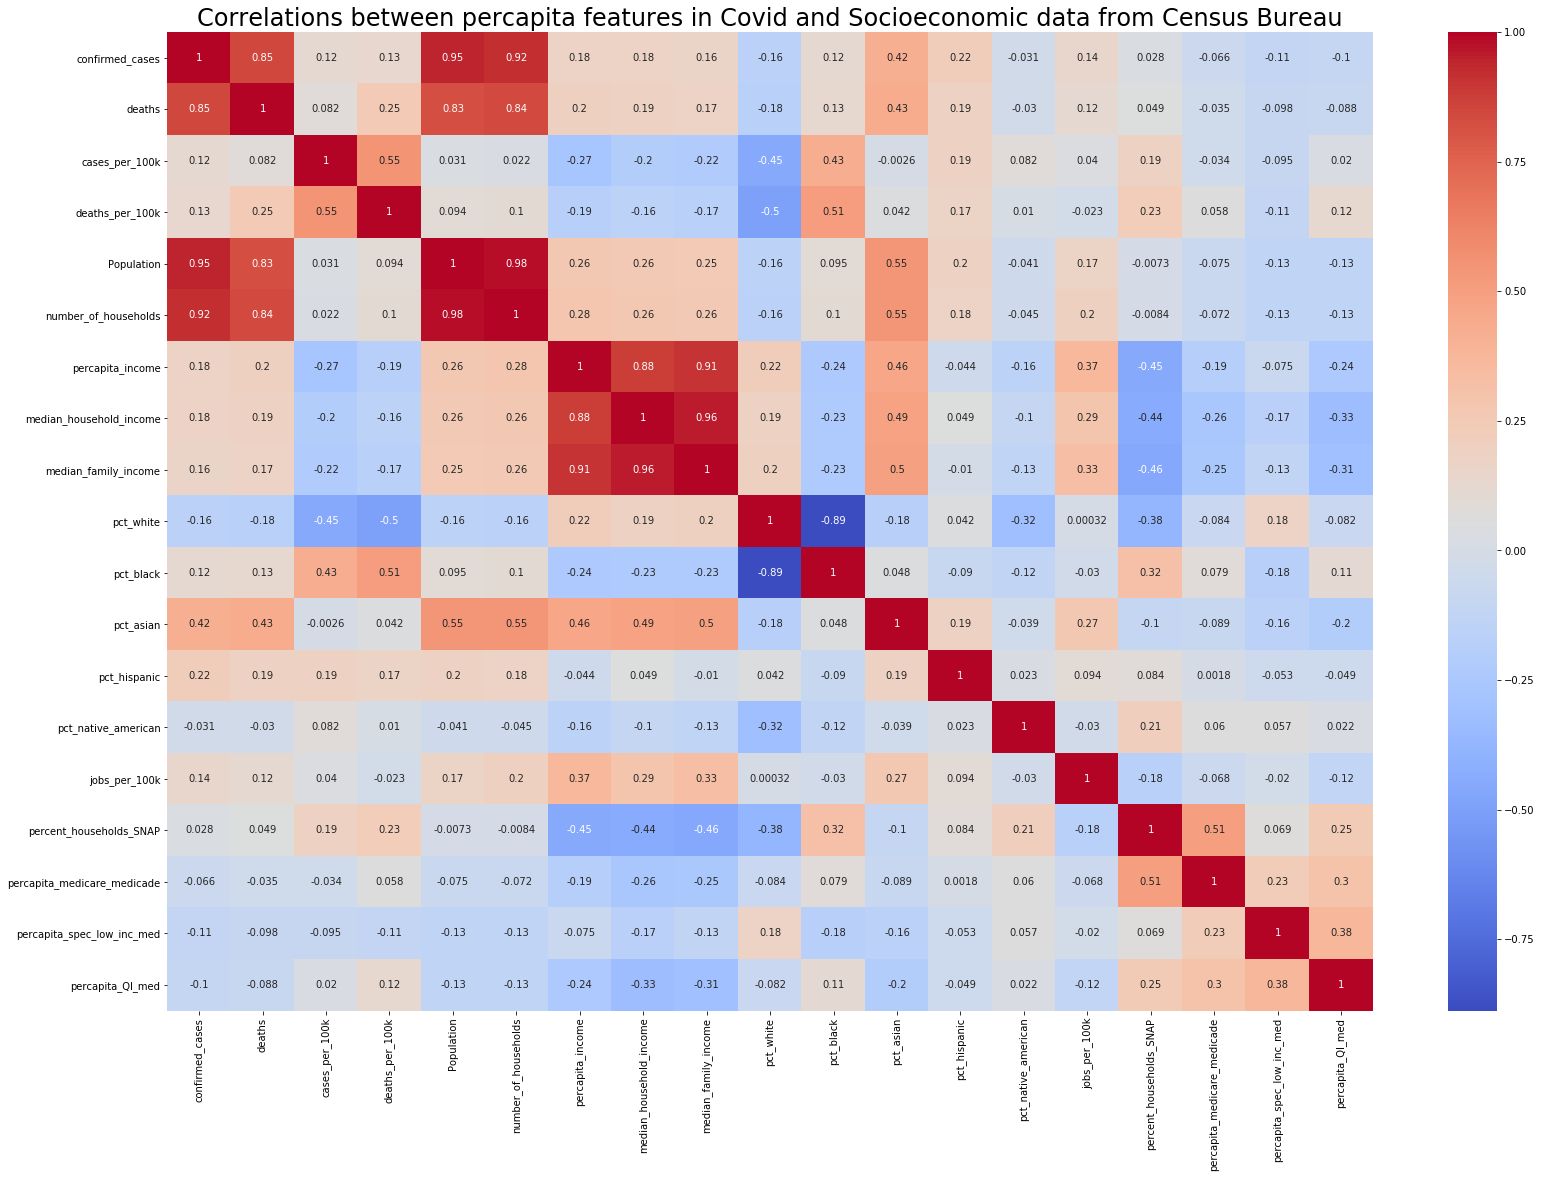

In [125]:
plt.figure(figsize=(27, 18))
sns.heatmap(df_lower[covid_feats + percapita].corr(), cmap='coolwarm', annot=True);
plt.title("Correlations between percapita features in Covid and Socioeconomic data from Census Bureau", 
          fontsize=24);

## This is interesting! 

There is a positive correlation between the percapita deaths and the percapita SNAP recipients within each county, but the same is not true for the cases percapita. So counties with higher percentages of people on food stamps have a higher likelihood of people dying from covid, but not a higher rate of people with confirmed cases of covid. This could be due to less access to testing in low-income areas, or it could suggest that areas with higher SNAP enrollees have a higher likelihood to die from Covid due to health reasons. 

## Run K-Means clusters and put the results into the data table

In [151]:
covid_feats_percapita = ['deaths_per_100k', 'cases_per_100k']
model_df = df_lower[all_feats + covid_feats_percapita]
model_features = all_feats + covid_feats_percapita

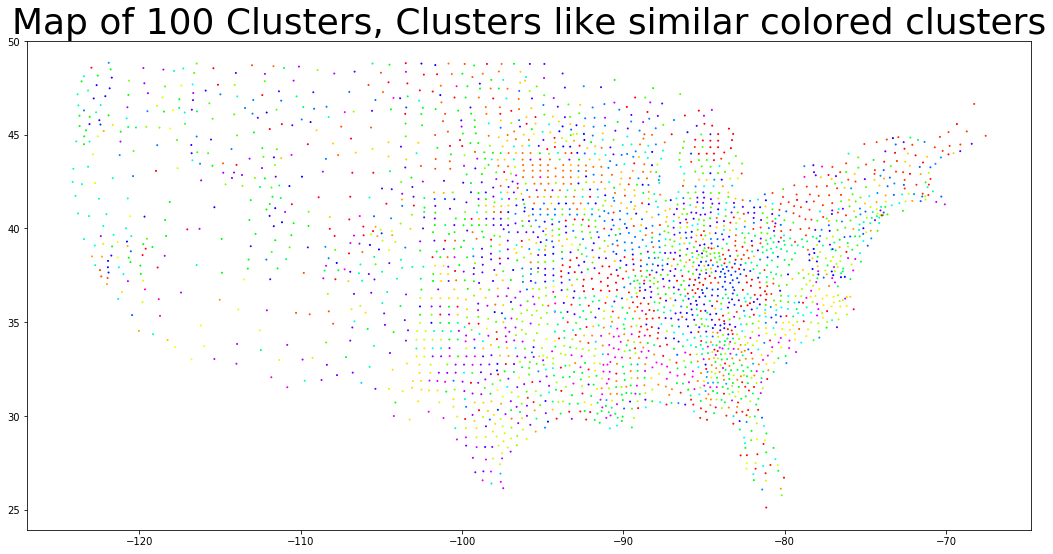

In [152]:
model_1 = cluster_map(df_lower, model_features, 100, cmap='gist_rainbow');

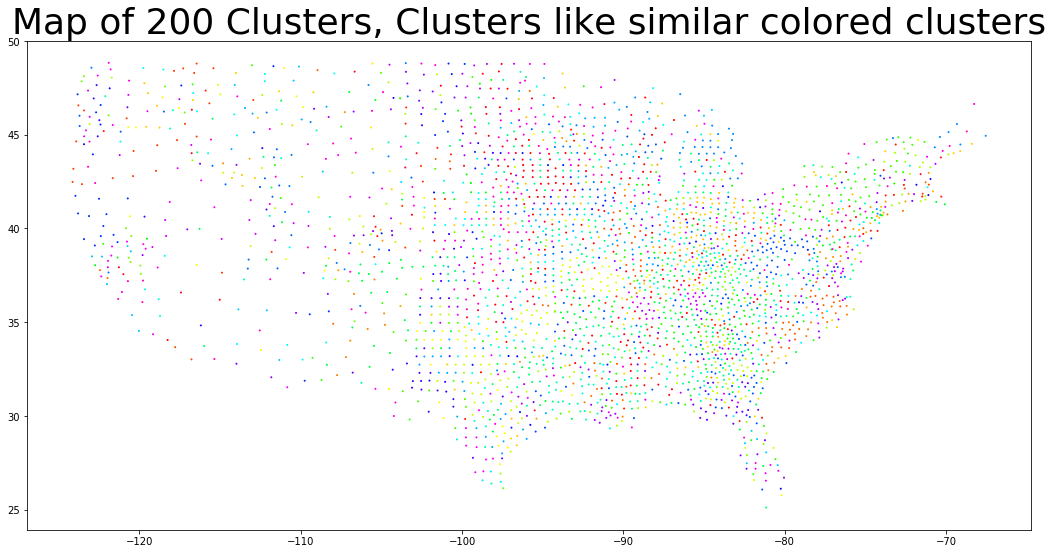

In [153]:
model_2 = cluster_map(df_lower, model_features, 200, cmap='gist_rainbow');

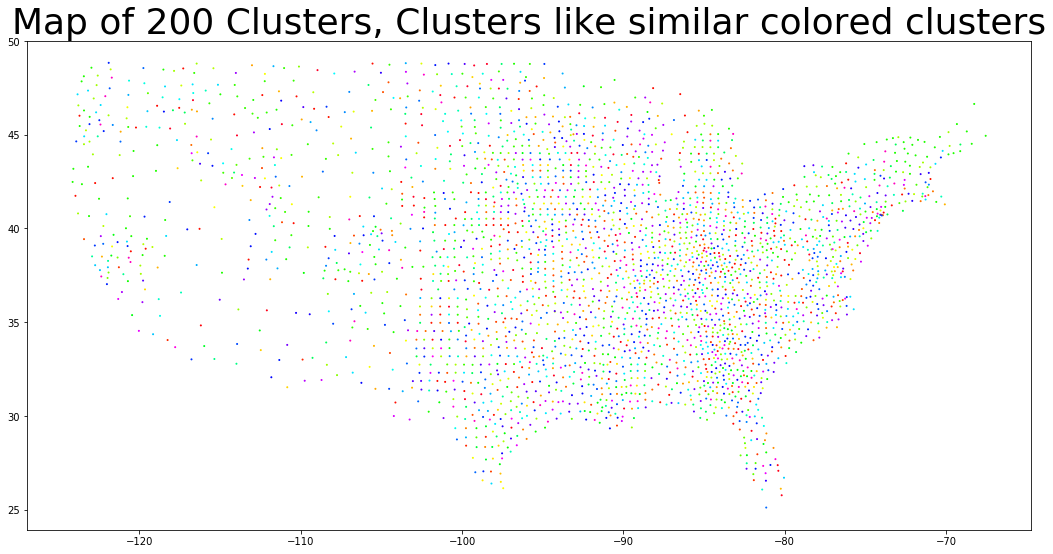

In [154]:
covid_only_2 = cluster_map(df_lower, covid_feats, 200, cmap='gist_rainbow');

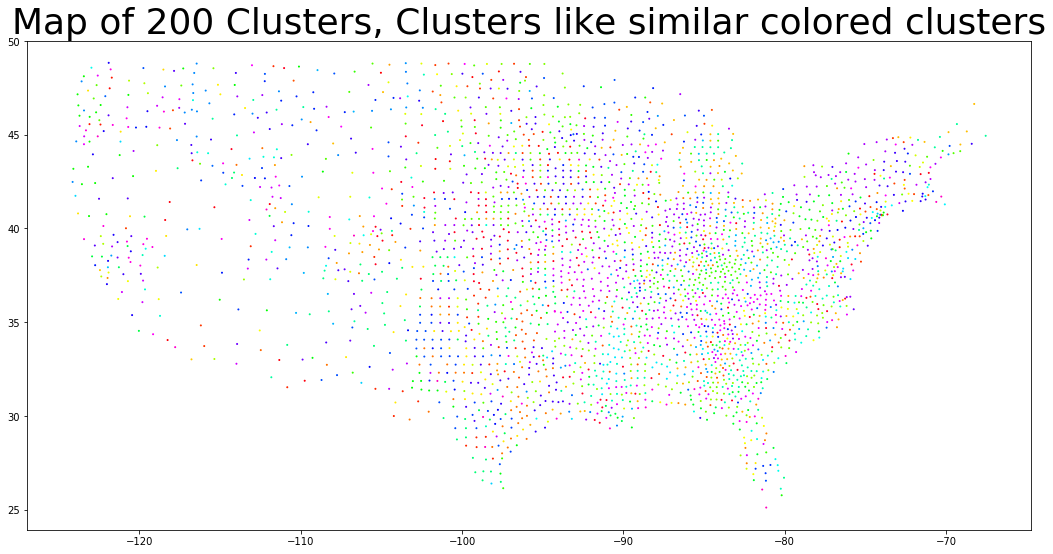

In [129]:
# model_features_2A = pct_ethnos + financial
# model_2A = cluster_map(big_data, model_features_2A, 200, cmap='gist_rainbow');

## Now complete the API in Tableau and mirror in Google Data Studio